In [24]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader

In [25]:
data = pd.read_csv("data/diamonds.csv")
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [26]:
le_cut = LabelEncoder()
le_color = LabelEncoder()
le_clarity = LabelEncoder()

data["cut"] = le_cut.fit_transform(data["cut"])
data["color"] = le_color.fit_transform(data["color"])
data["clarity"] = le_clarity.fit_transform(data["clarity"])

data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


In [27]:
X = data.drop("price", axis=1).values
y = data["price"].values

In [28]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape, X_val.shape, X_test.shape)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

(30206, 9) (7552, 9) (16182, 9)


In [29]:
class SequenceDataset(Dataset):
    def __init__(self, X, y, sequence_length=9):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length + 1

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.sequence_length], self.y[idx+self.sequence_length-1])

In [30]:
train_dataset = SequenceDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = SequenceDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = SequenceDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [53]:
class DiamondsRegression(nn.Module):
    def __init__(self):
        super(DiamondsRegression, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=1)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = DiamondsRegression().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [56]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    train_loss = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.unsqueeze_(1)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        train_total += labels.size(0)
    train_losses.append(train_loss / train_total)

    net.eval()
    val_loss = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs.unsqueeze_(1)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            val_total += labels.size(0)
    val_losses.append(val_loss / val_total)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

Epoch [10/50], Train Loss: 12371553.7348, Validation Loss: 10567965.3818
Epoch [20/50], Train Loss: 10922994.3904, Validation Loss: 9162833.4692
Epoch [30/50], Train Loss: 10276780.0758, Validation Loss: 8673976.8431
Epoch [40/50], Train Loss: 9565457.5169, Validation Loss: 8511565.6909
Epoch [50/50], Train Loss: 9238165.6822, Validation Loss: 8099233.0297


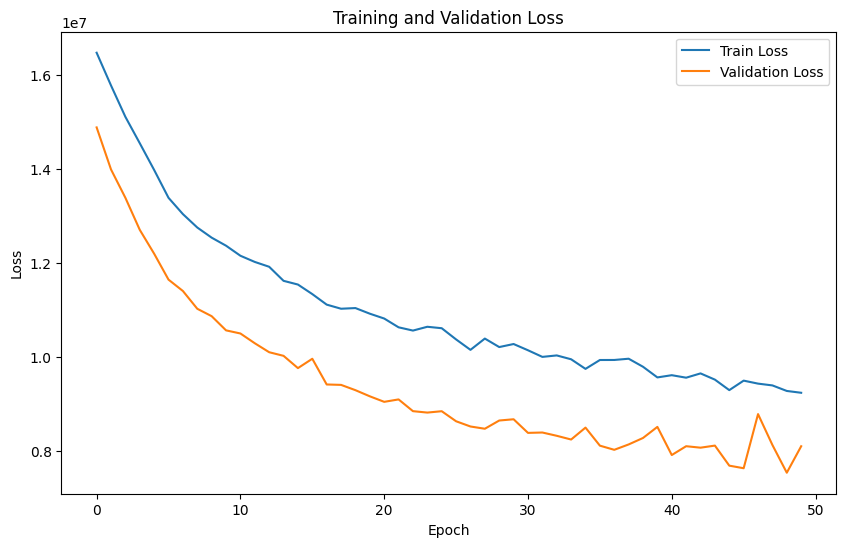

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.close()

In [59]:
test_mae = 0
test_mse = 0
test_r2 = 0

net.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs.unsqueeze(1))

        running_mae = mean_absolute_error(labels.cpu().numpy(), outputs.cpu().numpy())
        running_mse = mean_squared_error(labels.cpu().numpy(), outputs.cpu().numpy())
        running_r2 = r2_score(labels.cpu().numpy(), outputs.cpu().numpy())

        test_mae += running_mae * labels.size(0)
        test_mse += running_mse * labels.size(0)
        test_r2 += running_r2 * labels.size(0)

test_mae /= len(test_loader.dataset)
test_mse /= len(test_loader.dataset)
test_r2 /= len(test_loader.dataset)

print('Final Results:')
print(f'\tMean Absolute Error: {test_mae:.4f}')
print(f'\tMean Squared Error: {test_mse:.4f}')
print(f'\tr2 Score: {test_r2:.4f}')

Final Results:
	Mean Absolute Error: 1797.8728
	Mean Squared Error: 7568639.6758
	r2 Score: 0.5091
